### Prepare Samples for Classification
Here I am going to work with the raster file masked.tif created from the Sentinel 2 product, which was subset and cropped to the size of the Co Dublin administrative area, and with training_data2.shp file containing polygons of classes, created earlier in QGIS.

In [24]:
library(raster)
library(plyr)
set.seed(1)
setwd("~/RDemo/capstone/Sentinel2data")

In [25]:
img <- brick("masked.tif")
img

class       : RasterBrick 
dimensions  : 5061, 3570, 18067770, 7  (nrow, ncol, ncell, nlayers)
resolution  : 10, 10  (x, y)
extent      : 663550, 699250, 5895810, 5946420  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=utm +zone=29 +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0 
data source : C:/Users/Roxana/Documents/RDemo/capstone/Sentinel2data/masked.tif 
names       : masked.1, masked.2, masked.3, masked.4, masked.5, masked.6, masked.7 
min values  :       22,        0,        0,        0,        0,        0,        0 
max values  :     5672,    17776,    16832,    16208,    15984,    15811,    15708 


In [26]:
shp <- shapefile("C://Users/Roxana/Documents/RDemo/capstone/QGISprocessed/training_data2.shp")
shp

class       : SpatialPolygonsDataFrame 
features    : 119 
extent      : 666408.6, 695795.1, 5896519, 5945420  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=utm +zone=29 +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0 
variables   : 1
names       : classes 
min values  :       b 
max values  :       w 

Check if the projections of the two datasets are identical:

In [27]:
compareCRS(shp, img)

[1] TRUE

In [28]:
x <- as.factor(shp$classes)
levels(x)

[1] "b"   "c"   "f"   "g"   "ind" "rh"  "rl"  "w"

Give our classes meaningful names:

In [29]:
x <- revalue(x, c("b"="bareland", "c"="cropland", "f"="forest", "g"="green_area",
             "ind"="industrial", "rh"="residential_high","rl"="residential_low", "w"="water"))
levels(x)

[1] "bareland"         "cropland"         "forest"           "green_area"      
[5] "industrial"       "residential_high" "residential_low"  "water"

Will take a note of the each corresponding number of classes as will need it later on in QGIS for validation process:

In [30]:
for (i in 1:length(unique(x))) {
  cat(paste0(i, " ", levels(x)[i]), sep="\n")
}

1 bareland
2 cropland
3 forest
4 green_area
5 industrial
6 residential_high
7 residential_low
8 water


Convert the classes column into factor data type as classifiers can only work with integers instead of character strings like *water* or *forest*

In [31]:
for (i in 1:length(unique(shp$classes))) {
  cat(paste0(i, " ", levels(as.factor(shp$classes))[i]), sep="\n")
}

1 b
2 c
3 f
4 g
5 ind
6 rh
7 rl
8 w


In [32]:
names(img) # name of the bands

[1] "masked.1" "masked.2" "masked.3" "masked.4" "masked.5" "masked.6" "masked.7"

In [33]:
names(img) <- c("b1", "b2", "b3", "b4", "b5", "b6", "b7") # change names of the bands

Extract samples with class labels from initial dataset and put them all together in a dataframe. It is a way of ensuring we work with unbiased data. Depending on the spatial resolution of raster data, this may take some time.

In [34]:
smp <- extract(img, shp, df = TRUE)

The data frame has as many rows as pixels could be extracted and as many columns as input features are given - in this example the spectral channels. In addition, smp also provides a column named ID, which holds the IDs of the former polygon for each pixel (each polygon is automatically assigned an ID). Furthermore, we also know which polygon (each ID) belongs to which class. Because of this, we can establish a relationship between the deposited ID of each pixel and the class using the match()  function. We use this to add another column to our data query describing each class:

In [35]:
head(smp)

ID,b1,b2,b3,b4,b5,b6,b7
1,1201,719,926,1212,1615,1445,1664
1,1201,1222,1382,1334,1615,1445,1664
1,1201,1282,1382,1724,1705,1923,1822
1,1201,1496,1660,1818,1705,1923,1822
1,935,680,767,784,1051,1047,978
1,935,766,748,901,1051,1047,978


In [36]:
smp$cl <- as.factor( shp$classes[ match(smp$ID, seq(nrow(shp)) ) ] )
smp <- smp[-1] # delete the ID column
head(smp)

b1,b2,b3,b4,b5,b6,b7,cl
1201,719,926,1212,1615,1445,1664,ind
1201,1222,1382,1334,1615,1445,1664,ind
1201,1282,1382,1724,1705,1923,1822,ind
1201,1496,1660,1818,1705,1923,1822,ind
935,680,767,784,1051,1047,978,ind
935,766,748,901,1051,1047,978,ind


In [37]:
# save the resulting object to the hard drive
save(smp, file="smp.rda")

In [38]:
summary(smp$cl) # how many pixels per class

b    c    f    g  ind   rh   rl    w 
1200 2673  352  435  948  513  460  309

In [39]:
table(shp$classes) # how many samples (polygons) were drawn per class


  b   c   f   g ind  rh  rl   w 
  2  17  11  11   9  21  40   8 

We can visualise the differentiation of our classes per band by creating a spectral profiles plot:

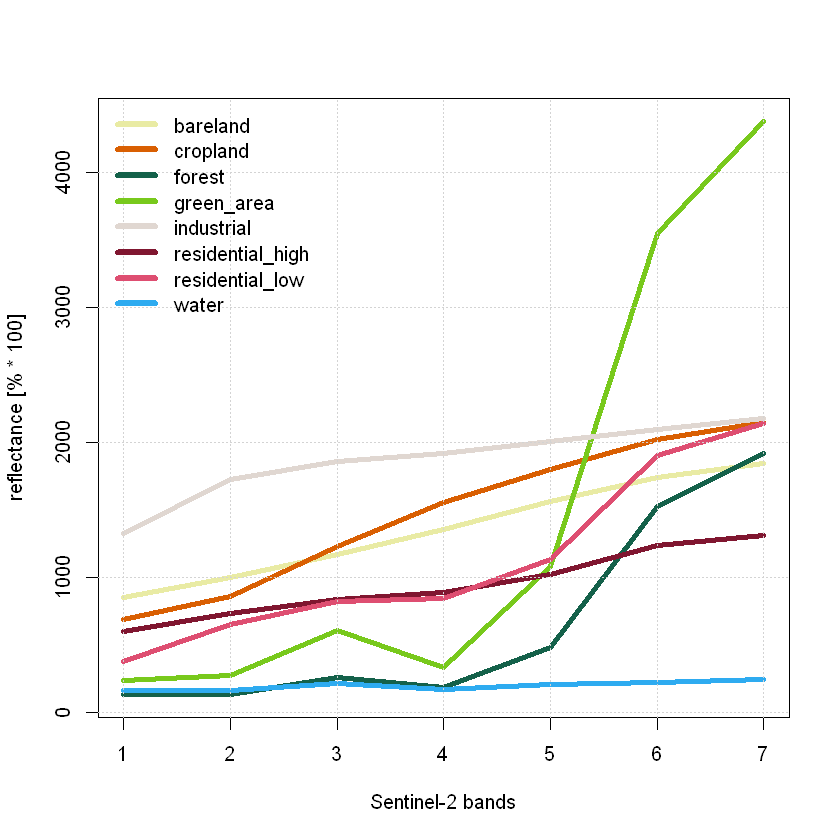

In [40]:
sp <- aggregate( . ~ cl, data = smp, FUN = mean, na.rm = TRUE )
# plot empty plot of a defined size
plot(0,
     ylim = c(min(sp[2:ncol(sp)]), max(sp[2:ncol(sp)])), 
     xlim = c(1, ncol(smp)-1), 
     type = 'n', 
     xlab = "Sentinel-2 bands", 
     ylab = "reflectance [% * 100]"
)
# define colors for class representation, one color per class
mycolors <- c("#e9eba4","#D95F02","#14614a","#78c91c","#e0d7d1","#801630","#de4e71","#2eabf0")
# draw one line for each class
for (i in 1:nrow(sp)){
  lines(as.numeric(sp[i, -1]), 
        lwd = 4, 
        col = mycolors[i]
  )
}
# add a grid
grid()
# add a legend
sp$cl <- revalue(sp$cl, c("b"="bareland", "c"="cropland", "f"="forest", "g"="green_area",
                  "ind"="industrial", "rh"="residential_high","rl"="residential_low", "w"="water"))
legend(as.character(sp$cl),
       x = "topleft",
       col = mycolors,
       lwd = 5,
       bty = "n"
)